In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/Variants/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/SIR_Origin/*.csv'
dic_SIRs = Load_files.load_files(path, -17, -15)

data = dic_files['대구']
data

,stdDay,Susceptible,22D_Infected,22D_Recovered,22D_dead,22D_alpha,22D_beta,22D_gamma,23A_Infected,23A_Recovered,23A_dead,23A_alpha,23A_beta,23A_gamma
0,2022-12-19,1154500,467.04,0.00,0.00,7.709827,0.000000,0.0,9.73,0.00,0.0,7.709827,0.000000,0.0
1,2022-12-20,1150875,2207.04,0.00,0.00,1.632581,0.000000,0.0,45.98,0.00,0.0,1.632581,0.000000,0.0
2,2022-12-21,1147259,3942.72,0.00,0.00,0.810531,0.000000,0.0,82.14,0.00,0.0,0.810531,0.000000,0.0
3,2022-12-22,1144062,5477.28,0.00,0.00,0.486252,0.000000,0.0,114.11,0.00,0.0,0.486252,0.000000,0.0
4,2022-12-23,1141405,6752.64,0.00,0.00,0.420776,0.000000,0.0,140.68,0.00,0.0,0.420776,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-04-30,1031603,503.31,68965.31,79.76,0.106662,0.063420,0.0,1695.36,9188.34,9.9,0.106662,0.063420,0.0
133,2023-05-01,1031481,494.57,68997.23,79.76,0.427119,0.164810,0.0,1665.92,9295.86,9.9,0.427119,0.164810,0.0
134,2023-05-02,1031001,504.26,69078.74,79.76,0.405137,0.161643,0.0,1698.56,9570.42,9.9,0.405137,0.161643,0.0
135,2023-05-03,1030537,510.91,69160.25,79.76,0.505227,0.147267,0.0,1720.96,9844.98,9.9,0.505227,0.147267,0.0


In [3]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 300
hidden_size = 32
num_layers = 4
batch_size = 8
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data[:-1], 'stdDay', '22D_alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 54, 60, 7, batch_size, 'mtm')
model_GRU_seq2seq = GRU_encoder_decoder(input_size = input_size,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers, 
                                        dropout = dropout, 
                                        device = device).to(device)

model = model_GRU_seq2seq

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([54, 60, 3])
torch.Size([54, 7, 1])
torch.Size([14, 60, 3])
torch.Size([14, 7, 1])


In [4]:
loss_list, model = Trainer.Many_to_Many(train_loader, 
                                        test_loader, 
                                        model, 
                                        criterion, 
                                        optimizer, 
                                        num_epochs, 
                                        patience,
                                        device)

epoch: 100 loss: 0.016486
epoch: 200 loss: 0.015615
epoch: 300 loss: 0.015521
epoch: 400 loss: 0.014265
epoch: 500 loss: 0.014266
epoch: 600 loss: 0.013765
epoch: 700 loss: 0.012959
epoch: 800 loss: 0.012571
epoch: 900 loss: 0.011875
epoch: 1000 loss: 0.011676
epoch: 1100 loss: 0.011158
epoch: 1200 loss: 0.010583
epoch: 1300 loss: 0.009553
epoch: 1400 loss: 0.008444
epoch: 1500 loss: 0.004087
epoch: 1600 loss: 0.003145
epoch: 1700 loss: 0.002440
epoch: 1800 loss: 0.002200
epoch: 1900 loss: 0.001983
epoch: 2000 loss: 0.002223
epoch: 2100 loss: 0.001675
epoch: 2200 loss: 0.001586
epoch: 2300 loss: 0.001436
epoch: 2400 loss: 0.001515
epoch: 2500 loss: 0.001298
epoch: 2600 loss: 0.001348
epoch: 2700 loss: 0.001177
epoch: 2800 loss: 0.001138
epoch: 2900 loss: 0.001023
epoch: 3000 loss: 0.000874
epoch: 3100 loss: 0.001004
epoch: 3200 loss: 0.000833
epoch: 3300 loss: 0.000884
epoch: 3400 loss: 0.000756
epoch: 3500 loss: 0.000752
epoch: 3600 loss: 0.000732
epoch: 3700 loss: 0.000622
epoch: 380

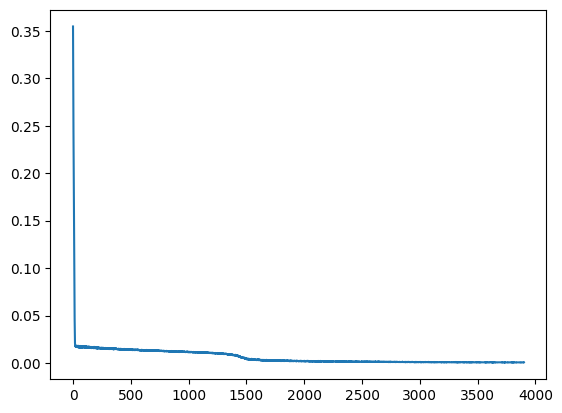

In [5]:
plt.plot(loss_list)

In [6]:
label_y, predicted, first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, len(x_ss), 7, 0.5, device)

56.88338279724121


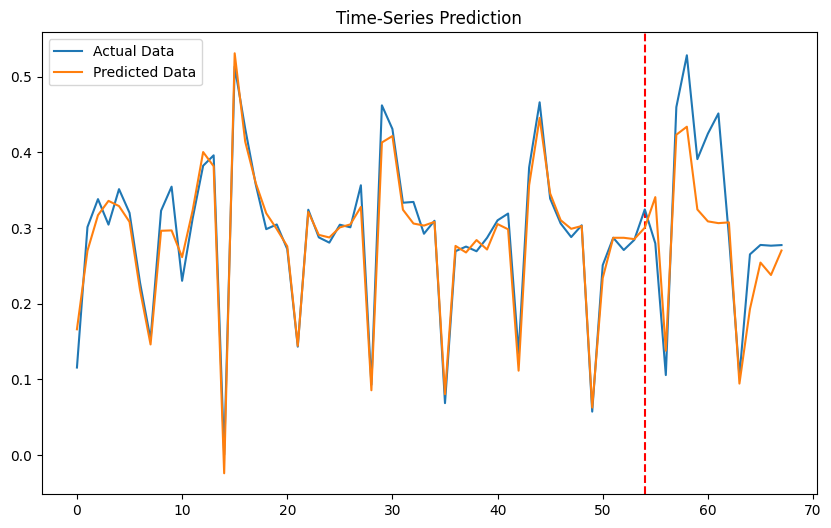

In [7]:
print(mape(first_label_y, first_predicted))
plotting(first_label_y, first_predicted, 54)

In [8]:
con_prediction = np.concatenate((predicted[-15].squeeze(-1), predicted[-8].squeeze(-1)), axis = 0)

data_predicted = data[['stdDay']].copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[69:, -1] = first_predicted
data_predicted.iloc[123:, -1] = con_prediction
data_predicted['predicted_22D'] = data['22D_Infected']
for i in range(123, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data.iloc[i-1, 6]-data.iloc[i-1, 7]
                                    +(data_predicted.iloc[i-1, 1]*data.iloc[i-1, 1]
                                      /dic_SIRs['대구'].iloc[0, 2])))
data_predicted

,stdDay,predicted_alpha,predicted_22D
0,2022-12-19,0.000000,467.040000
1,2022-12-20,0.000000,2207.040000
2,2022-12-21,0.000000,3942.720000
3,2022-12-22,0.000000,5477.280000
4,2022-12-23,0.000000,6752.640000
...,...,...,...
132,2023-04-30,0.370882,716.309854
133,2023-05-01,0.084249,785.592608
134,2023-05-02,0.313127,684.693697
135,2023-05-03,0.343459,666.537362


2.489919496088457


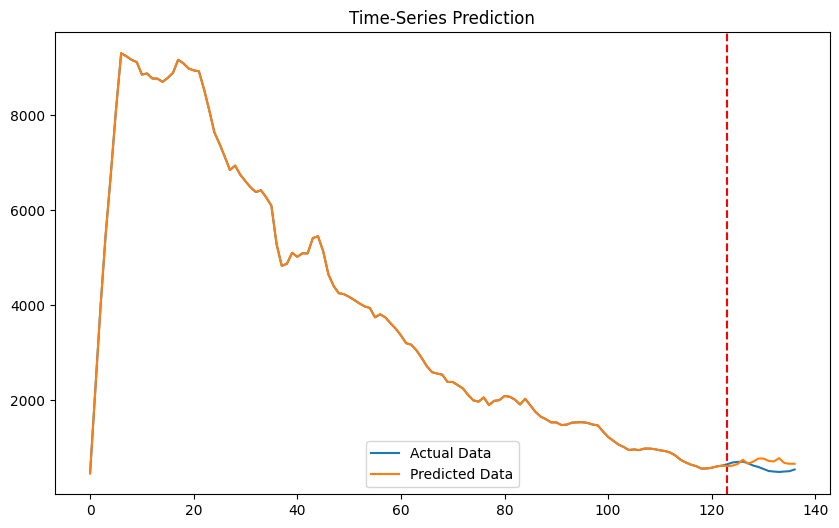

In [9]:
print(mape(data['22D_Infected'], data_predicted['predicted_22D']))
plotting(data['22D_Infected'], data_predicted['predicted_22D'], 123)

In [19]:
torch.save(model.state_dict(), 'Capstone/22D_2weeks_seq2seqGRU.pth')

In [20]:
alpha_df = pd.DataFrame()
alpha_df['Date'] = data_predicted['stdDay']
alpha_df['Actual_Data'] = data['22D_alpha']
alpha_df['Predicted_Data'] = data_predicted['predicted_alpha']
alpha_df.to_csv('Capstone/22D_alpha_seq2seqGRU.csv', encoding = 'cp949', index = False)

In [21]:
final_df = pd.DataFrame()
final_df['Date'] = data_predicted['stdDay']
final_df['Actual_Data'] = data['22D_Infected']
final_df['Predicted_Data'] = data_predicted['predicted_22D']
final_df.to_csv('Capstone/22D_Infected_seq2seqGRU.csv', encoding = 'cp949', index = False)